# Data creation 

In [1]:
from cleaning_image import Cleaning_image
from data_creation import Data_creation
from models import Models_pollen
import os
import pandas as pd
import numpy as np
import pickle as pick
from warnings import filterwarnings
filterwarnings("ignore")

botanical_species=32
seed=42
color_space="uv"
data_creation=Data_creation(botanical_species=botanical_species,seed=seed)
cleaning_image=Cleaning_image(botanical_species=botanical_species,seed=seed)

## Initial base

In [2]:
Control=pd.read_excel("Control/Control.xlsx")
Control.sort_values(by="Productor",inplace=True)

photographer_foldder=os.listdir("images")

visit_folder=os.listdir("images/F1")

images=list()
data=list()
for f in photographer_foldder[:2]:
        for v in visit_folder:
            images=[f"images/{f}/{v}/"+i for i in os.listdir(f"images/{f}/{v}/")]+images
            for i in images:
                data.append((int(i[13:15]), int(i[15:17]),int(i[17:19]), int(i[19:21]), int(i[21:23]),
                            Control.drop_duplicates(subset="Nombre")["Nombre"][Control["Productor"]==int(i[15:17])].values[0],
                            i))
df_initial=pd.DataFrame(data,columns=["Photographer","Producer", "Sample", "Visit", "Moment", "Name", "Link"])
df_initial.drop_duplicates(inplace=True)
df_initial.reset_index(drop=True,inplace=True)
df_initial

,Photographer,Producer,Sample,Visit,Moment,Name,Link
0,1,1,1,1,1,SAMAEL GUERRERO,images/F1/V1/0101010101.jpg
1,1,1,1,1,2,SAMAEL GUERRERO,images/F1/V1/0101010102.jpg
2,1,1,2,1,1,SAMAEL GUERRERO,images/F1/V1/0101020101.jpg
3,1,1,2,1,2,SAMAEL GUERRERO,images/F1/V1/0101020102.jpg
4,1,1,3,1,1,SAMAEL GUERRERO,images/F1/V1/0101030101.jpg
...,...,...,...,...,...,...,...
4567,3,20,10,4,2,EMMEYE PULIDO,images/F2/V4/0320100402.jpg
4568,3,20,11,4,1,EMMEYE PULIDO,images/F2/V4/0320110401.jpg
4569,3,20,11,4,2,EMMEYE PULIDO,images/F2/V4/0320110402.jpg
4570,3,20,12,4,1,EMMEYE PULIDO,images/F2/V4/0320120401.jpg


## Photo cleaning collection

In [5]:
croped_rate=0.1
width_image=450
high_image=300

for i in range(1,df_initial["Visit"].max()+1):
        photos_data=data_creation.data_photo_collection(df_initial["Link"][(df_initial["Visit"]==i)], # & (df_initial["Moment"]==np.random.choice([1,2]))],
                                        color_space=color_space,sav=True,sav_name=f"data_image_part{i}", croped_rate=croped_rate, 
                                        sav_path="Z:/unal/Tesis/Imagenes/Code/data/",width_image=width_image,high_image=high_image)

The file was saved in .pkl format in the path Z:/unal/Tesis/Imagenes/Code/data/
The file was saved in .pkl format in the path Z:/unal/Tesis/Imagenes/Code/data/
The file was saved in .pkl format in the path Z:/unal/Tesis/Imagenes/Code/data/
The file was saved in .pkl format in the path Z:/unal/Tesis/Imagenes/Code/data/


## Klustering model for getting of the colors representation

In [ ]:
photo_dimension=len(color_space)

cleaned_data=list()

for i in range(1,df_initial["Visit"].max()+1):
    a=pick.load(open(f'data/data_image_part{i}.pkl',"rb"))
    cleaned_data=cleaned_data+a

len(cleaned_data)

clustering_model, center_representation=data_creation.color_represent_data(cleaned_photos_array=cleaned_data,
                iterations=250, max_iter_kmeans=300, max_iter_minikmeans=100, sub_cluster_rate=1e-6, sub_data_rate=0.5,
                sav=True, sav_name=f"group_model_32_uv",sav_path="Z:/unal/Tesis/Imagenes/Code/models/")



## Proportion data base

In [5]:
photo_dimension=len(color_space)

cleaned_data=list()

for i in range(1,df_initial["Visit"].max()+1):
    a=pick.load(open(f'data/data_image_part{i}.pkl',"rb"))
    cleaned_data=cleaned_data+a

len(cleaned_data)

4572

In [6]:
c1=pick.load(open(f'models/group_model_32_uv.sav',"rb"))
c2=pick.load(open(f'models/model32_cel_uv.sav',"rb"))

In [ ]:
# clustering_model=pick.load(open(f'models/group_model_32_uv.sav',"rb"))
# center_representation=clustering_model.cluster_centers_
center_representation=c1.cluster_centers_
df_prop=pd.DataFrame(columns=data_creation.columnas())
df_prop

for im in cleaned_data:
    labels_photo=c2.predict(im.reshape(-1,photo_dimension))
    data_prop=data_creation.charac_vector(labes_colors=labels_photo, center_color_representation=center_representation,
                                          color_vector_out=np.array([ 96, 136]), cleaning_level=15)
    data_prop.shape
    df_prop=pd.concat([df_prop,pd.DataFrame(np.c_[data_prop].T, columns=data_creation.columnas())])
df_prop.reset_index(drop=True,inplace=True)
df_model=pd.concat([df_initial[["Moment","Producer","Name","Sample", "Visit","Photographer"]].reset_index(drop=True),df_prop],axis=1)
df_model.reset_index(drop=True)
df_model.to_excel("data/dfmodelcel_32_uv.xlsx",index=False)

# Model training

In [3]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from graphics_results import Graphic_results

data_control=pd.read_excel("../Control.xlsx")
df_model=pd.read_excel("data/Esp_ref32_cel_uv.xlsx")
df_model_1=pd.read_excel("data/dfmodelcel_32_uv.xlsx")
df_model.rename(columns={"Toma_fotografia":"Moment", "Productor": "Producer", "Nombre": "Name"},inplace=True)
df_model[["Sample", "Visit", "Photographer"]]=df_model_1[["Sample", "Visit", "Photographer"]]

model_pollen=Models_pollen(data=df_model,botanical_species=botanical_species,seed=seed)
graphic_results=Graphic_results(botanical_species=botanical_species, seed=seed)
rate_split=2/3

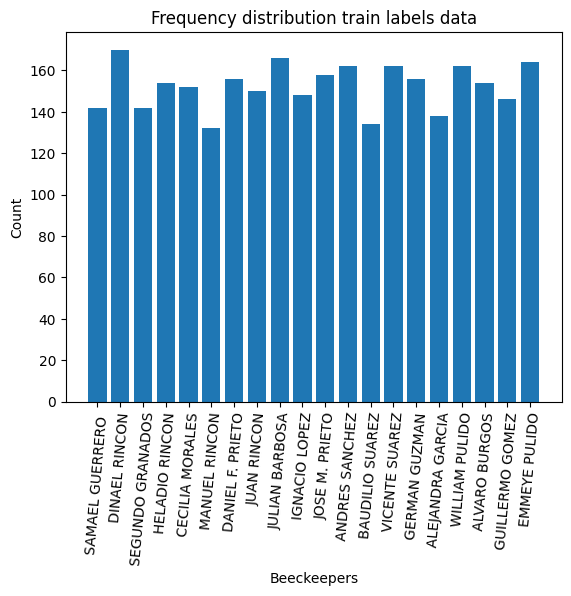

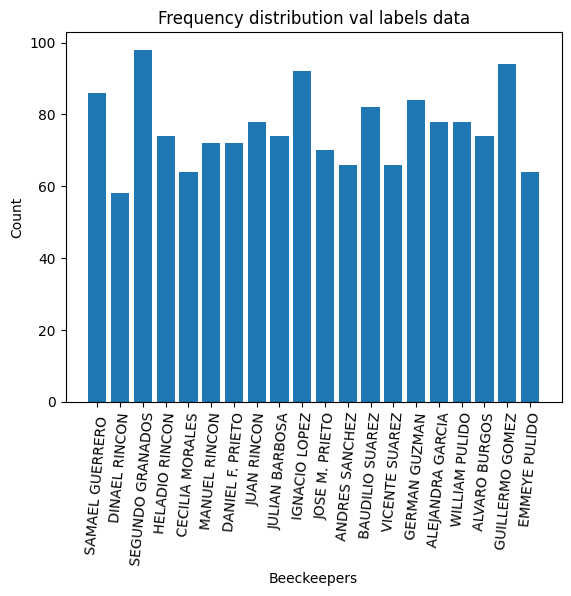

In [4]:
## Data partition
X_train,Y_train,X_val,Y_val,Positions,pos_val = model_pollen.Partition_balanced(cant_visitas=4,rate_split=2/3)

## Label names
Producer=df_initial[["Producer","Name"]].sort_values(by="Producer")["Name"].unique()

plt.bar(Producer,height=np.unique_counts(Y_train["Producer"])[1])
plt.xlabel("Beeckeepers")
plt.ylabel("Count")
plt.xticks(rotation=85, fontsize=10)
plt.title("Frequency distribution train labels data")
plt.show()


plt.bar(Producer,height=np.unique_counts(Y_val["Producer"])[1])
plt.xlabel("Beeckeepers")
plt.ylabel("Count")
plt.xticks(rotation=85, fontsize=10)
plt.title("Frequency distribution val labels data")
plt.show()

In [27]:
parameters_list=[{"C":np.arange(0.9,1,0.01), "kernel":["poly"], "degree":[ 6 , 7, 8], "coef0":np.arange(0.1,2,0.1),
                "decision_function_shape":["ovr"]}]

model_estimators=[SVC(class_weight="balanced", random_state=seed, gamma="scale", tol=5e-4)
                  ]
scoring=["f1_weighted", "roc_auc_ovr"]
model_names=["SVC"]

results_models=model_pollen.model_tunning(estimator_models=model_estimators, params_dict=parameters_list, score_list=scoring,names_model=model_names,
                                   X_train=X_train.drop(columns="Visit"), Y_train=Y_train.drop(columns="Visit"),cv=3)

n_iterations: 3
n_required_iterations: 6
n_possible_iterations: 3
min_resources_: 120
max_resources_: 3048
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 570
n_resources: 120
Fitting 3 folds for each of 570 candidates, totalling 1710 fits
----------
iter: 1
n_candidates: 190
n_resources: 360
Fitting 3 folds for each of 190 candidates, totalling 570 fits
----------
iter: 2
n_candidates: 64
n_resources: 1080
Fitting 3 folds for each of 64 candidates, totalling 192 fits
n_iterations: 3
n_required_iterations: 6
n_possible_iterations: 3
min_resources_: 120
max_resources_: 3048
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 570
n_resources: 120
Fitting 3 folds for each of 570 candidates, totalling 1710 fits
----------
iter: 1
n_candidates: 190
n_resources: 360
Fitting 3 folds for each of 190 candidates, totalling 570 fits
----------
iter: 2
n_candidates: 64
n_resources: 1080
Fitting 3 folds for each of 64 candidates, totalling 192 fits


### f1_weighted

In [28]:
results_models[0][3].get_params()

{'C': np.float64(0.9500000000000001),
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': np.float64(1.9000000000000001),
 'decision_function_shape': 'ovr',
 'degree': 7,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.0005,
 'verbose': False}

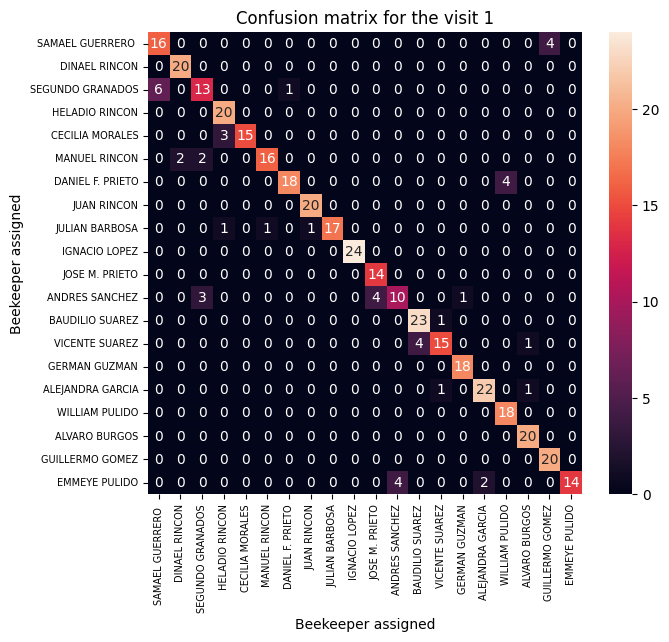

              precision    recall  f1-score   support

           1       0.73      0.80      0.76        20
           2       0.91      1.00      0.95        20
           3       0.72      0.65      0.68        20
           4       0.83      1.00      0.91        20
           5       1.00      0.83      0.91        18
           6       0.94      0.80      0.86        20
           7       0.95      0.82      0.88        22
           8       0.95      1.00      0.98        20
           9       1.00      0.85      0.92        20
          10       1.00      1.00      1.00        24
          11       0.78      1.00      0.88        14
          12       0.71      0.56      0.62        18
          13       0.85      0.96      0.90        24
          14       0.88      0.75      0.81        20
          15       0.95      1.00      0.97        18
          16       0.92      0.92      0.92        24
          17       0.82      1.00      0.90        18
          18       0.91    

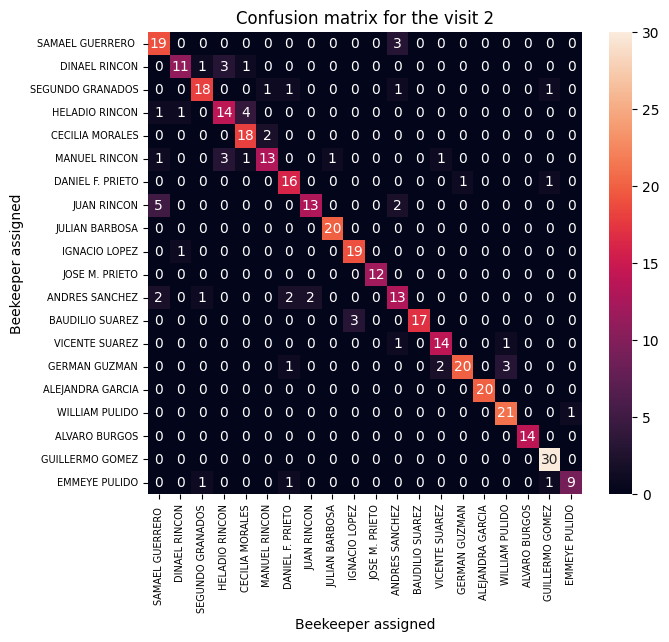

              precision    recall  f1-score   support

           1       0.68      0.86      0.76        22
           2       0.85      0.69      0.76        16
           3       0.86      0.82      0.84        22
           4       0.70      0.70      0.70        20
           5       0.75      0.90      0.82        20
           6       0.81      0.65      0.72        20
           7       0.76      0.89      0.82        18
           8       0.87      0.65      0.74        20
           9       0.95      1.00      0.98        20
          10       0.86      0.95      0.90        20
          11       1.00      1.00      1.00        12
          12       0.65      0.65      0.65        20
          13       1.00      0.85      0.92        20
          14       0.82      0.88      0.85        16
          15       0.95      0.77      0.85        26
          16       1.00      1.00      1.00        20
          17       0.84      0.95      0.89        22
          18       1.00    

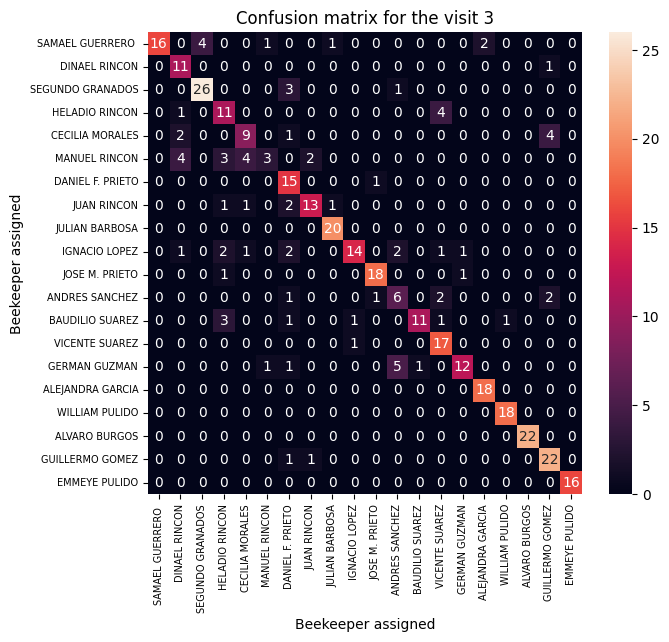

              precision    recall  f1-score   support

           1       1.00      0.67      0.80        24
           2       0.58      0.92      0.71        12
           3       0.87      0.87      0.87        30
           4       0.52      0.69      0.59        16
           5       0.60      0.56      0.58        16
           6       0.60      0.19      0.29        16
           7       0.56      0.94      0.70        16
           8       0.81      0.72      0.76        18
           9       0.91      1.00      0.95        20
          10       0.88      0.58      0.70        24
          11       0.90      0.90      0.90        20
          12       0.43      0.50      0.46        12
          13       0.92      0.61      0.73        18
          14       0.68      0.94      0.79        18
          15       0.86      0.60      0.71        20
          16       0.90      1.00      0.95        18
          17       0.95      1.00      0.97        18
          18       1.00    

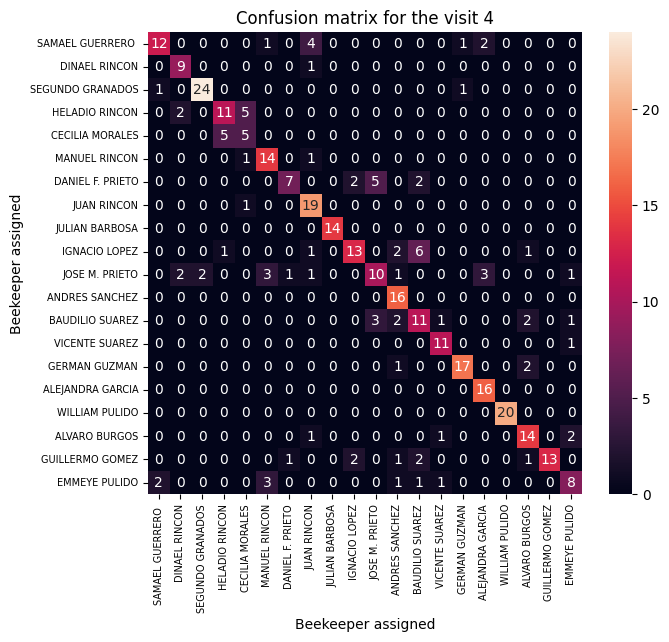

              precision    recall  f1-score   support

           1       0.80      0.60      0.69        20
           2       0.69      0.90      0.78        10
           3       0.92      0.92      0.92        26
           4       0.65      0.61      0.63        18
           5       0.42      0.50      0.45        10
           6       0.67      0.88      0.76        16
           7       0.78      0.44      0.56        16
           8       0.68      0.95      0.79        20
           9       1.00      1.00      1.00        14
          10       0.76      0.54      0.63        24
          11       0.56      0.42      0.48        24
          12       0.67      1.00      0.80        16
          13       0.50      0.55      0.52        20
          14       0.79      0.92      0.85        12
          15       0.89      0.85      0.87        20
          16       0.76      1.00      0.86        16
          17       1.00      1.00      1.00        20
          18       0.70    

,Visit,balanced_Accuracy,Recall_weighted,Precision_weighted,f1_score_weighted
0,1,0.881604,0.882500,0.887544,0.879493
1,2,0.847849,0.848718,0.854957,0.847306
2,3,0.780139,0.788360,0.808755,0.781603
3,4,0.749973,0.741573,0.752057,0.734555


In [29]:
SVC_model1=results_models[1][3]
visit=4
columns_metrics=["Visit", "balanced_Accuracy", "Recall_weighted", "Precision_weighted", "f1_score_weighted"]
results_metrics=pd.DataFrame(columns=columns_metrics)
for k in range(1,visit+1):
    X_validation=X_val[X_val["Visit"]==k].drop(columns="Visit")
    Y_validation=Y_val[Y_val["Visit"]==k].drop(columns="Visit")
    y_pred=SVC_model1.predict(X_validation)
    acc, recall, preci, f1score, conf_matrix = graphic_results.get_results(y_test=Y_validation,pred_y=y_pred,save_image=True, eje=Producer, 
                                                                    path_image=f"images_result/Confusion_matrix_visit_{k}",
                                                                    format_image="jpg", tittle_image=f"Confusion matrix for the visit {k}")
    results_metrics= pd.concat([results_metrics, pd.DataFrame([[k, acc, recall, preci, f1score]], columns=columns_metrics)],axis=0)
results_metrics.reset_index(drop=True, inplace=True)
results_metrics


### roc_auc_ovr

# Model creration

# Results